## TL;DR
*Train a model to predict INACBG based on ICD9 and ICD10 codes using Random Forest Classification.*

**Data Input:** 201k data

**Algorithm:** Random Forest

**Test Data:** 10% dari 201k

**Akurasi:** 0.76

**Nama Model:** ./predict-inacbg/model/01_RF_201k.joblib

**Encoder:** ./predict-inacbg/encoders/01_RF_201k_encoder.joblib

## Cek Lokasi Saat Ini

In [1]:
!pwd

/home/intern/ai-inacbg


In [2]:
import pandas as pd
df = pd.read_csv('ai_inacbg.csv', sep=';')

nama_model = './predict-inacbg/model/01_RF_201k.joblib'
nama_encoder = './predict-inacbg/encoders/01_RF_201k_encoder.joblib'

## Explore Data

In [3]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nUnique Values per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Display sample of data
print("\nSample Data:")

Dataset Shape: (278785, 10)

Missing Values:
ID                  0
Tanggal             0
RegID           71085
SEPID               1
INACBG          77440
ICD10          159585
ICD9           103427
INACBG_Desc     77440
ICD10_Desc     159586
ICD9_Desc      103427
dtype: int64

Unique Values per Column:
ID: 278785 unique values
Tanggal: 154321 unique values
RegID: 89244 unique values
SEPID: 104825 unique values
INACBG: 588 unique values
ICD10: 4420 unique values
ICD9: 916 unique values
INACBG_Desc: 588 unique values
ICD10_Desc: 4369 unique values
ICD9_Desc: 919 unique values

Sample Data:


In [4]:
df.head()

,ID,Tanggal,RegID,SEPID,INACBG,ICD10,ICD9,INACBG_Desc,ICD10_Desc,ICD9_Desc
0,1,2023-09-01 02:07:14,P230900003,0901R0030923V000001,Q-5-42-0,NaN,8907.0,PENYAKIT AKUT KECIL LAIN-LAIN,NaN,"Consultation, described as comprehensive"
1,2,2023-09-01 02:07:14,P230900003,0901R0030923V000001,Q-5-42-0,NaN,9922.0,PENYAKIT AKUT KECIL LAIN-LAIN,NaN,Injection of other anti-infective
2,3,2023-09-01 09:52:27,P230900494,0901R0030923V000428,Q-5-44-0,N30,8907.0,PENYAKIT KRONIS KECIL LAIN-LAIN,Cystitis,"Consultation, described as comprehensive"
3,4,2023-09-01 09:52:27,P230900494,0901R0030923V000428,Q-5-44-0,N30.9,NaN,PENYAKIT KRONIS KECIL LAIN-LAIN,"Cystitis, unspecified",NaN
4,5,2023-09-01 13:34:31,P230900609,0901R0030923V001192,Q-5-44-0,C11,8907.0,PENYAKIT KRONIS KECIL LAIN-LAIN,Malignant neoplasm of nasopharynx,"Consultation, described as comprehensive"


### Take only necessary fields

In [7]:
df = df[['ICD9', 'ICD10', 'INACBG']]
df.head()

,ICD9,ICD10,INACBG
0,8907.0,NaN,Q-5-42-0
1,9922.0,NaN,Q-5-42-0
2,8907.0,N30,Q-5-44-0
3,NaN,N30.9,Q-5-44-0
4,8907.0,C11,Q-5-44-0


## Clean Data

In [8]:
df_clean = df.copy()
# Print initial row count
print(f"Initial row count: {len(df_clean)}")

# 1. Remove rows where INACBG is null
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['INACBG'])
rows_removed = rows_before - len(df_clean)
print(f"Rows removed due to null INACBG: {rows_removed}")

# 2. Remove rows where both ICD9 and ICD10 are null
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['ICD9', 'ICD10'], how='all')
rows_removed = rows_before - len(df_clean)
print(f"Rows removed due to both ICD9 and ICD10 being null: {rows_removed}")

# Optional: Clean string values (remove whitespace, standardize case)
string_columns = df_clean.select_dtypes(include=['object']).columns
for col in string_columns:
    df_clean[col] = df_clean[col].str.strip() if df_clean[col].dtype == 'object' else df_clean[col]
    df_clean[col] = df_clean[col].str.upper() if df_clean[col].dtype == 'object' else df_clean[col]


print(f"Final row count: {len(df_clean)}")

Initial row count: 278785
Rows removed due to null INACBG: 77440
Rows removed due to both ICD9 and ICD10 being null: 81
Final row count: 201264


In [9]:
print("\nDataset Shape After Cleaning:", df_clean.shape)
print("\nMissing Values After Cleaning:")
print(df_clean.isnull().sum())

# Analyze remaining data
print("\nSummary of cleaned data:")
print("Number of unique INACBG codes:", df_clean['INACBG'].nunique())
print("Number of unique ICD9 codes:", df_clean['ICD9'].nunique())
print("Number of unique ICD10 codes:", df_clean['ICD10'].nunique())

# Check for rows with only ICD9 or only ICD10
only_icd9 = df_clean['ICD9'].notna() & df_clean['ICD10'].isna()
only_icd10 = df_clean['ICD10'].notna() & df_clean['ICD9'].isna()

print(f"\nRows with only ICD9: {sum(only_icd9)}")
print(f"Rows with only ICD10: {sum(only_icd10)}")
print(f"Rows with both ICD9 and ICD10: {sum(df_clean['ICD9'].notna() & df_clean['ICD10'].notna())}")



Dataset Shape After Cleaning: (201264, 3)

Missing Values After Cleaning:
ICD9      32009
ICD10     84679
INACBG        0
dtype: int64

Summary of cleaned data:
Number of unique INACBG codes: 587
Number of unique ICD9 codes: 902
Number of unique ICD10 codes: 4409

Rows with only ICD9: 84679
Rows with only ICD10: 32009
Rows with both ICD9 and ICD10: 84576


### Data Check After Clean

In [10]:
df_clean.reset_index(drop=True, inplace=False)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201264 entries, 0 to 278783
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ICD9    169255 non-null  float64
 1   ICD10   116585 non-null  object 
 2   INACBG  201264 non-null  object 
dtypes: float64(1), object(2)
memory usage: 6.1+ MB


## Data Prep

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def prepare_data(df):
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # Print initial data types
    print("Initial data types:")
    print(df.dtypes)
    
    # Convert numeric values to strings and handle missing values
    df['ICD9'] = df['ICD9'].astype(str)
    df['ICD10'] = df['ICD10'].astype(str)
    
    # Replace 'nan' strings with 'MISSING'
    df['ICD9'] = df['ICD9'].replace('nan', 'MISSING')
    df['ICD10'] = df['ICD10'].replace('nan', 'MISSING')
    
    # Initialize encoders
    icd9_encoder = LabelEncoder()
    icd10_encoder = LabelEncoder()
    inacbg_encoder = LabelEncoder()
    
    # Encode the features and target
    X_icd9 = icd9_encoder.fit_transform(df['ICD9'])
    X_icd10 = icd10_encoder.fit_transform(df['ICD10'])
    y = inacbg_encoder.fit_transform(df['INACBG'])
    
    # Print unique values count after encoding
    print("\nUnique values after encoding:")
    print(f"ICD9: {len(np.unique(X_icd9))} unique values")
    print(f"ICD10: {len(np.unique(X_icd10))} unique values")
    print(f"INACBG: {len(np.unique(y))} unique values")
    
    # Combine features
    X = np.column_stack((X_icd9, X_icd10))
    
    return X, y, (icd9_encoder, icd10_encoder, inacbg_encoder)


In [13]:
# Prepare data and set encoders
print("Step 1: Preparing data...")
X, y, encoders = prepare_data(df_clean)

Step 1: Preparing data...
Initial data types:
ICD9      float64
ICD10      object
INACBG     object
dtype: object

Unique values after encoding:
ICD9: 903 unique values
ICD10: 4410 unique values
INACBG: 587 unique values


## Data Split

In [14]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [15]:
# Hanya mengambil baris yang punya minimal 2 counts 
def split_data(X, y, min_samples_per_class=2):
    print("Analyzing initial class distribution...")
    class_counts = analyze_class_distribution(y)
    
    # Create a mask for samples with sufficient class representation
    valid_classes = [class_label for class_label, count 
                    in class_counts.items() if count >= min_samples_per_class]
    mask = np.isin(y, valid_classes)
    
    # Filter X and y
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    print(f"\nRemoved {sum(~mask)} samples from rare classes")
    print(f"Remaining samples: {len(y_filtered)}")
    
    try:
        # First split: Train + Validation vs Test (80:20)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_filtered, 
            y_filtered,
            test_size=0.1,
            random_state=42,
            stratify=y_filtered 
        )
        
        # Second split: Train vs Validation (80:20 of the remaining data)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, 
            y_temp,
            test_size=0.2,
            random_state=42,
            stratify=y_temp
        )

        # Test Data = 10% x full data
        # Train Data = 80% x (full data - test)
        # Validation Data = 20% x (full data - test)
        # Stratified: memastikan distribusi kelas ketika data split tetap dipertahankan
        
        # Print split sizes
        print("\nData Split Sizes:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        # Analyze class distribution in each split
        print("\nAnalyzing class distribution in splits...")
        print("Training set:")
        analyze_class_distribution(y_train)
        print("\nValidation set:")
        analyze_class_distribution(y_val)
        print("\nTest set:")
        analyze_class_distribution(y_test)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except ValueError as e:
        print("\nError in splitting data:", str(e))
        print("Please try adjusting the min_samples_per_class parameter or use a different splitting strategy")
        raise

def analyze_class_distribution(y):
    # Analyze class distribution. Yang dihitung hanya field INACBG karena targetnya
    class_counts = Counter(y)
    print("\nClass distribution analysis:")
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Minimum samples in a class: {min(class_counts.values())}")
    print(f"Maximum samples in a class: {max(class_counts.values())}")
    
    # Count classes with few samples
    rare_classes = sum(1 for count in class_counts.values() if count < 3)
    print(f"Number of classes with less than 3 samples: {rare_classes}")
    
    return class_counts


# Function to get detailed statistics about your data
def get_data_statistics(df, X, y):
    print("\nDetailed Data Statistics:")
    print(f"Total samples: {len(df)}")
    print(f"Features shape: {X.shape}")
    
    # Analyze INACBG distribution
    inacbg_counts = df['INACBG'].value_counts()
    print(f"\nINACBG Distribution:")
    print(f"Number of unique INACBG codes: {len(inacbg_counts)}")
    print(f"Top 5 most common INACBG codes:")
    print(inacbg_counts.head())
    print(f"\nBottom 5 least common INACBG codes:")
    print(inacbg_counts.tail())
    
    return inacbg_counts

In [16]:
stats = get_data_statistics(df_clean, X, y)
    
# Then try splitting with different minimum samples threshold
try:
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, min_samples_per_class=2)
except ValueError:
    print("\nTrying with higher minimum samples threshold...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, min_samples_per_class=3)


Detailed Data Statistics:
Total samples: 201264
Features shape: (201264, 2)

INACBG Distribution:
Number of unique INACBG codes: 587
Top 5 most common INACBG codes:
INACBG
Q-5-44-0    96818
H-3-12-0    14996
M-3-16-0    12457
U-3-16-0     7806
N-3-15-0     6355
Name: count, dtype: int64

Bottom 5 least common INACBG codes:
INACBG
Q-5-22-0    2
C-3-15-0    2
C-3-17-0    2
I-1-12-I    2
C-3-14-0    1
Name: count, dtype: int64
Analyzing initial class distribution...

Class distribution analysis:
Total number of classes: 587
Minimum samples in a class: 1
Maximum samples in a class: 96818
Number of classes with less than 3 samples: 15

Removed 1 samples from rare classes
Remaining samples: 201263

Data Split Sizes:
Training set: 144908 samples
Validation set: 36228 samples
Test set: 20127 samples

Analyzing class distribution in splits...
Training set:

Class distribution analysis:
Total number of classes: 586
Minimum samples in a class: 2
Maximum samples in a class: 69709
Number of classe

### **Install RAPIDS agar bisa train Random Forest di GPU**

## Train

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def train_model_with_gridsearch(X_train, X_val, y_train, y_val, model_path=nama_model, encoders_path=nama_encoder):
    # Define parameter grid
    param_grid = {
        'n_estimators': [150],  # Number of trees
        'max_depth': [20],        # Maximum depth of trees
        'min_samples_split': [5],  # Minimum samples required to split
        'min_samples_leaf': [2],    # Minimum samples required at leaf node
        'max_features': ['sqrt']   # Number of features to consider at each split
    }
    
    # Initialize Random Forest
    rf = RandomForestClassifier(random_state=42, n_jobs=2)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        n_jobs=2,
        verbose=2,
        scoring='accuracy'
    )
    
    # Fit the model
    print("Starting GridSearchCV...")
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print("\nBest parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    # Evaluate on validation set
    val_pred = grid_search.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    print("\nValidation set accuracy:", val_accuracy)
    
    # Save the best model to a file
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_path)
    print(f"Model saved to {model_path}")
    
    # Save encoders (if applicable)
    # Assuming you have encoders for ICD9, ICD10, and INACBG
    encoders_2 = {
        'icd9_encoder': encoders[0],  # Replace with your actual encoder
        'icd10_encoder': encoders[1],  # Replace with your actual encoder
        'inacbg_encoder': encoders[2]  # Replace with your actual encoder
    }
    joblib.dump(encoders_2, encoders_path)
    print(f"Encoders saved to {encoders_path}")
    
    return best_model, grid_search.best_params_

def analyze_feature_importance(model, feature_names=['ICD9', 'ICD10']):
    # Get feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("\nFeature ranking:")
    for f in range(len(feature_names)):
        print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

def plot_learning_curves(model, X_train, X_val, y_train, y_val):
    train_scores = []
    val_scores = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        # Get subset of training data
        train_subset_size = int(len(X_train) * size)
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]
        
        # Train model
        model.fit(X_train_subset, y_train_subset)
        
        # Calculate scores
        train_scores.append(accuracy_score(y_train_subset, model.predict(X_train_subset)))
        val_scores.append(accuracy_score(y_val, model.predict(X_val)))
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, label='Training Score')
    plt.plot(train_sizes, val_scores, label='Validation Score')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
best_model, best_params = train_model_with_gridsearch(X_train, X_val, y_train, y_val)

Starting GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intern/ai-inacbg/inacbg-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(



Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best cross-validation score: 0.7624009750095929

Validation set accuracy: 0.7646571712487579
Model saved to ./predict-inacbg/model/01_RF_201k.joblib
Encoders saved to ./predict-inacbg/encoders/01_RF_201k_encoder.joblib



Feature ranking:
1. ICD9 (0.693806)
2. ICD10 (0.306194)


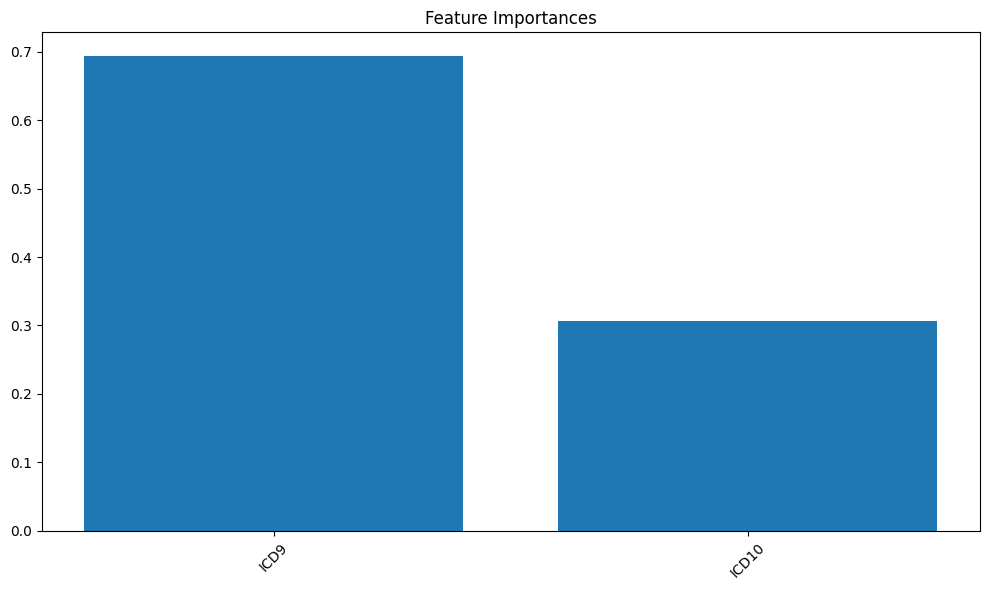

In [19]:
# Analyze feature importance
analyze_feature_importance(best_model)

## Evaluating

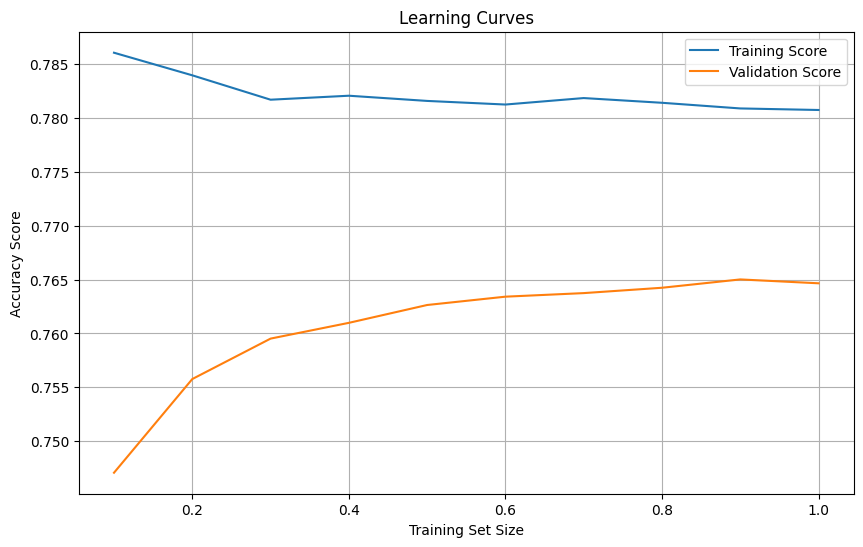

In [20]:
# Plot learning curves
plot_learning_curves(best_model, X_train, X_val, y_train, y_val)

## Predict Test

In [21]:
import joblib
import numpy as np
import pandas as pd

def load_model_and_encoders(model_path=nama_model, encoders_path=nama_encoder):
    """Load the trained model and encoders"""
    model = joblib.load(model_path)
    encoders = joblib.load(encoders_path)
    return model, encoders

def predict_single_case(model, encoders, icd9, icd10, top_k=3):
    """Make prediction for a single case"""
    icd9_encoder = encoders['icd9_encoder']
    icd10_encoder = encoders['icd10_encoder']
    inacbg_encoder = encoders['inacbg_encoder']
    
    # Handle missing values
    icd9 = str(icd9) if pd.notna(icd9) else 'MISSING'
    icd10 = str(icd10) if pd.notna(icd10) else 'MISSING'
    
    # Encode input
    try:
        X_icd9 = icd9_encoder.transform([icd9])
        X_icd10 = icd10_encoder.transform([icd10])
    except ValueError as e:
        print(f"Error: ICD code not found in training data: {str(e)}")
        return None
    
    # Combine features
    X = np.column_stack((X_icd9, X_icd10))
    
    # Get probabilities
    probabilities = model.predict_proba(X)[0]
    
    # Get top k predictions
    top_indices = np.argsort(probabilities)[-top_k:][::-1]
    top_codes = inacbg_encoder.inverse_transform(top_indices)
    top_probs = probabilities[top_indices]
    
    return list(zip(top_codes, top_probs))

In [22]:
df.head(15)

,ICD9,ICD10,INACBG
0,8907.0,NaN,Q-5-42-0
1,9922.0,NaN,Q-5-42-0
2,8907.0,N30,Q-5-44-0
3,NaN,N30.9,Q-5-44-0
4,8907.0,C11,Q-5-44-0
5,NaN,C11.9,Q-5-44-0
6,8907.0,C31,Q-5-44-0
7,9059.0,C31.9,Q-5-44-0
8,2219.0,NaN,U-3-13-0
9,8907.0,J02.9,U-3-13-0


In [23]:
# Load model dan encoders
model, encoders = load_model_and_encoders()

# Prediksi single case
predictions = predict_single_case(model, encoders, "8907.0", "J02.9")

for code, prob in predictions:
    print(f"INACBG: {code}, Confidence: {prob:.3f}")

INACBG: Q-5-43-0, Confidence: 0.387
INACBG: J-3-13-0, Confidence: 0.147
INACBG: J-4-15-III, Confidence: 0.135


In [24]:
print(model)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, n_jobs=2, random_state=42)


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  16.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  16.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  11.4s


: 